# Get the Data

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

medical = pd.read_csv("insurance.csv")

# Take a Quick Look at the Data Structure

In [53]:
medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [55]:
medical.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [56]:
medical.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


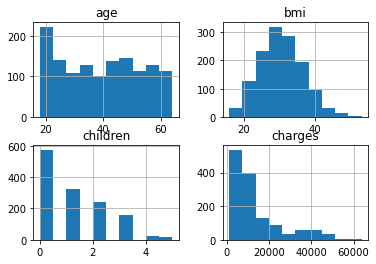

In [57]:
medical.hist()
plt.show()

In [58]:
# age, children and charges are positively skewed
# bmi is normal

## Create a Test Set

In [59]:
RS = 13

In [60]:
X = medical.drop(["charges"], axis = 1)
y = medical[["charges"]]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RS)

# Explore and Visualize the Data to Gain Insights

In [62]:
X_train

,age,sex,bmi,children,smoker,region
448,40,female,29.600,0,no,southwest
443,59,female,36.520,1,no,southeast
581,19,male,30.590,0,no,northwest
913,44,female,27.500,1,no,southwest
708,31,female,30.495,3,no,northeast
...,...,...,...,...,...,...
866,18,male,37.290,0,no,southeast
742,53,male,34.105,0,yes,northeast
74,44,male,27.400,2,no,southwest
176,38,male,27.835,2,no,northwest


In [63]:
train = X_train.copy()
train["charges"] = y_train.copy()

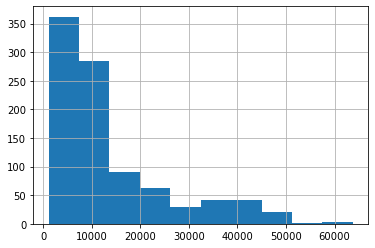

In [64]:
train["charges"].hist()
plt.show()

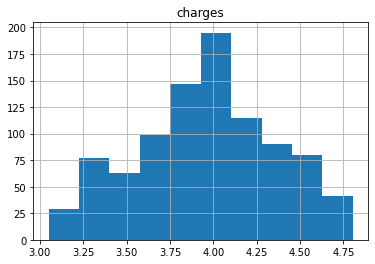

In [65]:
pd.DataFrame(np.log10(train.charges)).hist()
plt.show()

Now let's look at the mean charges by region

In [66]:
train[["region","charges"]].groupby(["region"]).mean()

,charges
region,
northeast,13265.552265
northwest,13225.413686
southeast,14871.818962
southwest,12466.903493


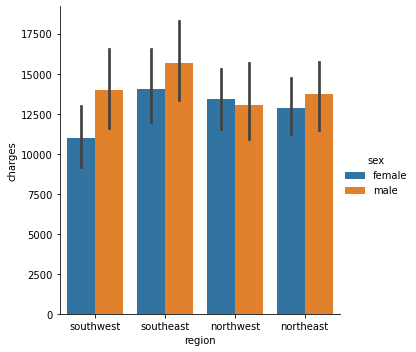

In [67]:
sns.catplot(data = train, x = "region", y = "charges", hue = "sex", kind = "bar")
plt.show()


In [68]:
# males charges are more than females (in 3/4 cases)
# southwest has the lowest charges for females
# northwest has the lowest charges for males
# southeast has the highest charges for both

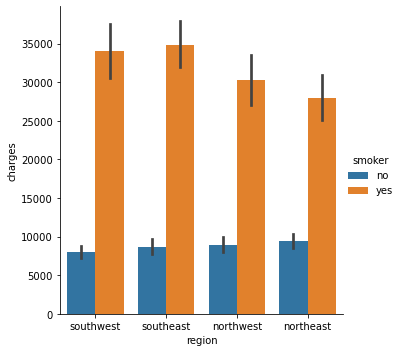

In [69]:
sns.catplot(data = train, x = "region", y = "charges", hue = "smoker", kind = "bar")
plt.show()


In [70]:
# smokers has 3 times more charges than non-smokers
# north east has the highest charges for non-smokers, but the lowest charges for smokers

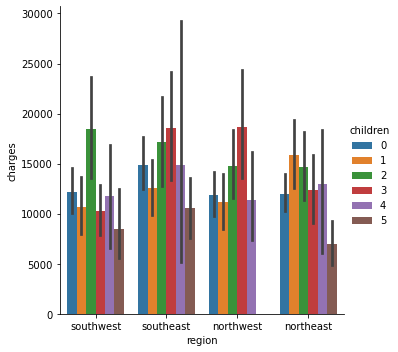

In [71]:
sns.catplot(data = train, x = "region", y = "charges", hue = "children", kind = "bar")
plt.show()


In [72]:
# in southwest family with 2 children has the highest charge and with 5 childern hast the lowest charge
# in southeast family with 3 children has the highest charge and with 5 children hast the lowest charge
# in northwest family with 3 children hast the highest charge and with 1 child has the lowest charge
# in northeast family with 1 child has the highest charge and with 5 children has the lowest charge

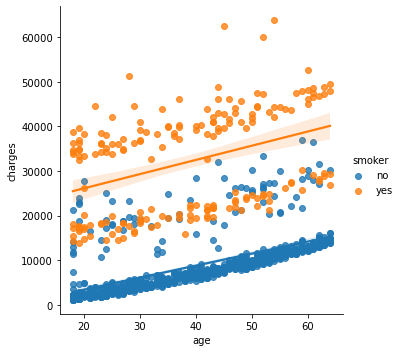

In [73]:
sns.lmplot(data = train,x = "age", y = "charges", hue = "smoker",)
plt.show()

In [74]:
# age and smoking both positively effect on charges 

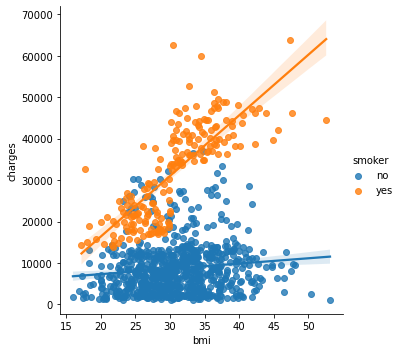

In [75]:
sns.lmplot(data = train,x = "bmi", y = "charges", hue = "smoker",)
plt.show()

In [76]:
# smoking highly effect on charges
# bmi effect on charges, but needs more clear plot for analyze   

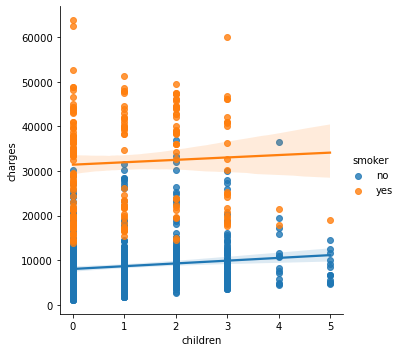

In [77]:
sns.lmplot(data = train,x = "children", y = "charges", hue = "smoker",)
plt.show()

In [78]:
# outliers of charges are mostly smokers and have less than 4 children

### Look for Correlations

In [79]:
train.corr()

,age,bmi,children,charges
age,1.000000,0.130788,0.025381,0.295932
bmi,0.130788,1.000000,0.023346,0.198454
children,0.025381,0.023346,1.000000,0.051307
charges,0.295932,0.198454,0.051307,1.000000


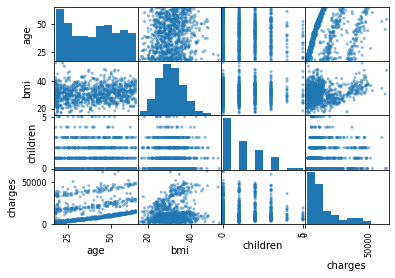

In [80]:
pd.plotting.scatter_matrix(train)
plt.show()

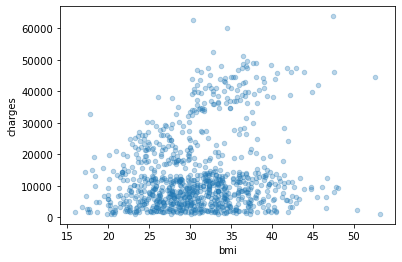

In [81]:
train.plot(kind = 'scatter', x = "bmi", y = 'charges', alpha = 0.3)
plt.show()

# Transformation Pipelines

In [82]:
num_attribs = ["age", "bmi", "children"]
cat_attribs = ["sex", "smoker", "region"]

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop = 'first'))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)])

X_train_perpared = preprocessing.fit_transform(X_train)

print(X_train_perpared.shape)
print(preprocessing.get_feature_names_out())

(936, 8)
['num__age' 'num__bmi' 'num__children' 'cat__sex_male' 'cat__smoker_yes'
 'cat__region_northwest' 'cat__region_southeast' 'cat__region_southwest']


# Select and Train a Model

## Train and Evaluate on the Training Set


In [83]:
lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("linear_regression",LinearRegression())
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('linear_regression', LinearRegression())])

In [84]:
y_predictions_lin = lin_reg.predict(X_test)
y_predictions_lin[:5]

array([[ 3578.74351013],
       [10216.27622265],
       [ 7398.59872957],
       [ 6238.60129349],
       [ 2562.75811151]])

In [85]:
lin_rmse = mean_squared_error(y_test, y_predictions_lin, squared=False)
lin_rmse

5834.133007290974

In [86]:
dt_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("decision_tree",DecisionTreeRegressor(random_state=RS))
])

dt_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('decision_tree', DecisionTreeRegressor(random_state=13))])

In [87]:
y_predictions_dt = dt_reg.predict(X_test)
y_predictions_dt[:5]

array([ 2055.3249 , 12224.35085,  4320.41085,  5227.98875,  2457.21115])

In [88]:
dt_rmse = mean_squared_error(y_test, y_predictions_dt, squared=False)
dt_rmse

6122.432350426551

# Better Evaluation Using Cross-Validation


In [89]:
tree_pipeline = Pipeline([
    ("preprocessing",preprocessing),
    ("tree", DecisionTreeRegressor(random_state = RS))
])

tree_rmses = cross_val_score(tree_pipeline, 
                              X_train, y_train,
                              scoring="neg_root_mean_squared_error", 
                              cv=10)
tree_rmses

array([-6265.29485138, -7377.28208902, -7085.38856846, -7997.65675418,
       -7567.24221623, -6805.94150941, -7849.43824253, -7307.06282526,
       -6137.19432622, -6172.97182115])

In [90]:
np.mean(tree_rmses * -1)

7056.547320386965

In [91]:
np.median(tree_rmses * -1)

7196.225696860822

In [92]:
rfr_reg = Pipeline([
    ("preprocessing",preprocessing),
    ("random_forest",RandomForestRegressor(random_state=RS))
])
rfr_reg.fit(X_train, y_train)

/home/amyrmahdy/.local/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('random_forest', RandomForestRegressor(random_state=13))])

In [93]:
y_predictions_rfr = rfr_reg.predict(X_test)
y_predictions_rfr[:5]

array([ 2401.83384026, 12397.9298855 ,  6870.0941465 ,  5123.836125  ,
        2875.93995009])

In [94]:
rfr_rmse = mean_squared_error(y_test, y_predictions_rfr, squared=False)
rfr_rmse

4251.558189926003

# Fine-Tune Your Model

## Randomized Search for Good Hyperparameters


In [95]:

full_pipeline = Pipeline([("preprocessing", preprocessing),
                          ("random_forest", RandomForestRegressor(random_state=RS))
                          ])

param_distribs = {'random_forest__max_features': randint(low=2,high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, 
                                param_distributions=param_distribs,
                                n_iter=10, 
                                cv=3,
                                scoring='neg_root_mean_squared_error', 
                                random_state=RS)
rnd_search.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=13))]),
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd329ed8850>},
                   random_state=13, scoring='neg_root_mean_squared_error')

In [96]:
rn_res = pd.DataFrame(rnd_search.cv_results_)
rn_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
rn_res.head(5)["mean_test_score"]

4   -5039.948650
7   -5039.948650
6   -5093.283311
9   -5152.495411
0   -5213.865327
Name: mean_test_score, dtype: float64

In [97]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances

array([0.14900893, 0.17895356, 0.02726622, 0.00850256, 0.61334952,
       0.00765398, 0.0084463 , 0.00681894])

In [98]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()),reverse=True)

[(0.6133495188155264, 'cat__smoker_yes'),
 (0.17895356150843594, 'num__bmi'),
 (0.14900892609866512, 'num__age'),
 (0.02726621957381335, 'num__children'),
 (0.008502558710902405, 'cat__sex_male'),
 (0.008446295284785842, 'cat__region_southeast'),
 (0.00765397739374062, 'cat__region_northwest'),
 (0.006818942614130391, 'cat__region_southwest')]

In [99]:
final_rfr_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("final_random_forest", RandomForestRegressor(random_state=RS, max_features = 4))
])
 
final_rfr_reg.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('final_random_forest',
                 RandomForestRegressor(max_features=4, random_state=13))])

In [100]:
y_predictions_final_rfr = final_rfr_reg.predict(X_test)
y_predictions_final_rfr[:5]

array([ 3251.5963769, 12139.4326819,  5544.7433706,  5053.354543 ,
        2925.5519552])

In [101]:
final_rfr_rmse = mean_squared_error(y_test, y_predictions_final_rfr, squared=False)
final_rfr_rmse

4158.257085533594